# PSB injection bump in Xsuite - track!

In [ ]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_05_thin.json')
line.build_tracker()
tw = line.twiss()

line.vars['t_turn_s'] = 0 # avoid leftovers from previous scripts

Loading line from dict:   0%|          | 0/2396 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Enable chicane and chicane correction

In [4]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['on_chicane_beta_corr'] = 1
line.vars['on_chicane_tune_corr'] = 1

### Install monitor at foil

In [5]:
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=6000, particle_id_range=(0,50))

line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=monitor, name='monitor_at_foil')
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Generate some test particles

In [15]:
# p = xp.generate_matched_gaussian_bunch(num_particles=50, sigma_z=1e-3, nemitt_x=1e-8, nemitt_y=1.5e-8, line=line)

# # use the first particle as probe
# p.x[0] = 0
# p.px[0] = 0
# p.y[0] = 0
# p.py[0] = 0
# p.zeta[0] = 0
# p.delta[0] = 0
line.vars['t_turn_s'] = 0.
p = line.build_particles(zeta=np.linspace(-45, 45, 50))

### Enable time-dependent variables (update `t_turn_s` automatically during tracking)

In [16]:
line.enable_time_dependent_vars = True
# line.dt_update_time_dependent_vars = 3e-6
line.vars.cache_active = True
line.vars['t_turn_s'] = 0.

In [17]:
print('Tracking...')
line.track(p, num_turns=6000, time=True, with_progress=True)
print(f'Done in {line.time_last_track:.4} s')

Tracking...


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Done in 28.82 s


<IPython.core.display.Javascript object>


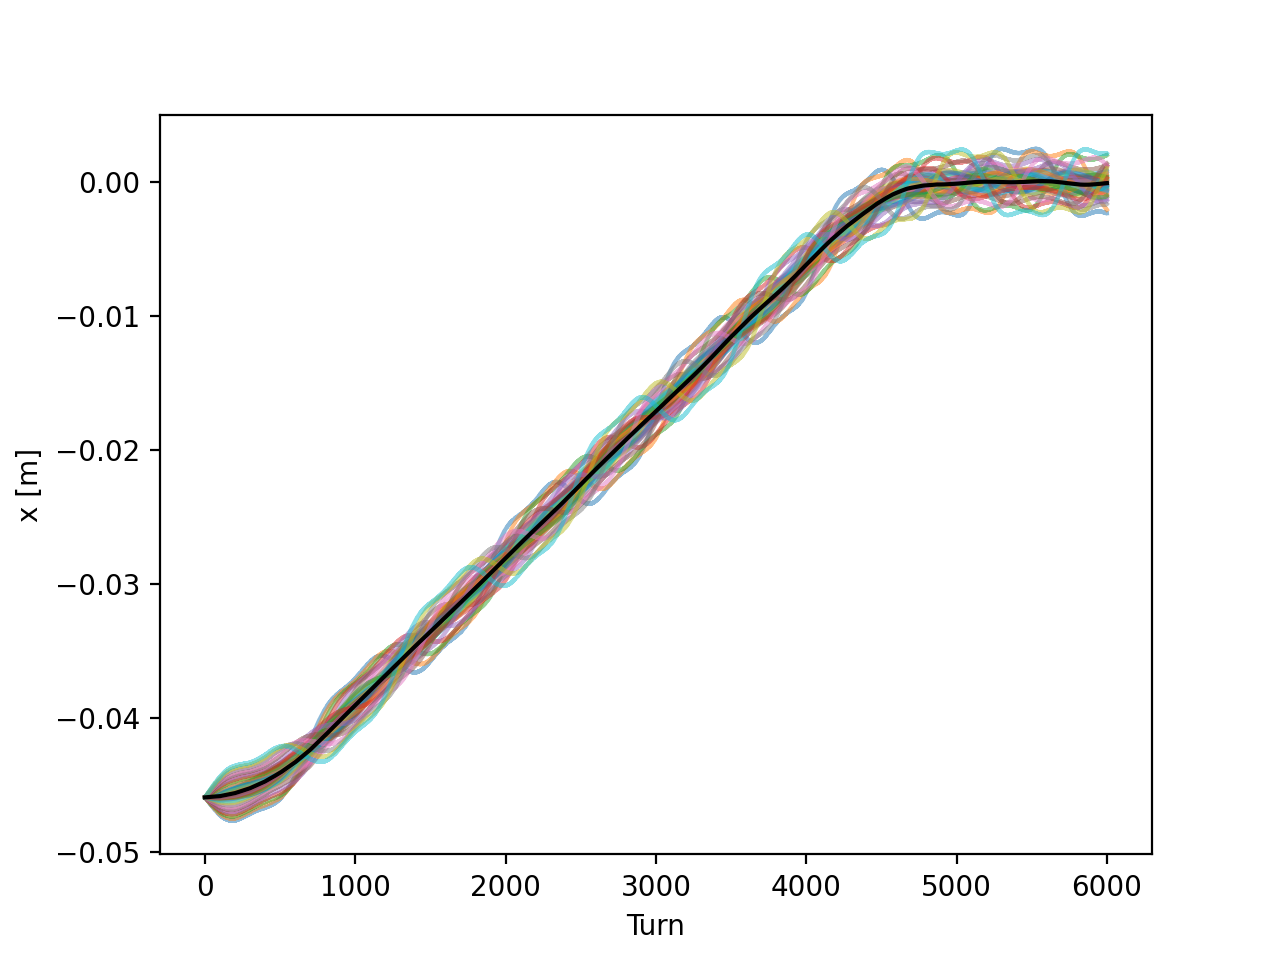

In [21]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(monitor.x.T, alpha=0.5)
plt.plot(np.mean(monitor.x, axis=0), color='k')
plt.xlabel('Turn')
plt.ylabel('x [m]')
plt.show()

<IPython.core.display.Javascript object>


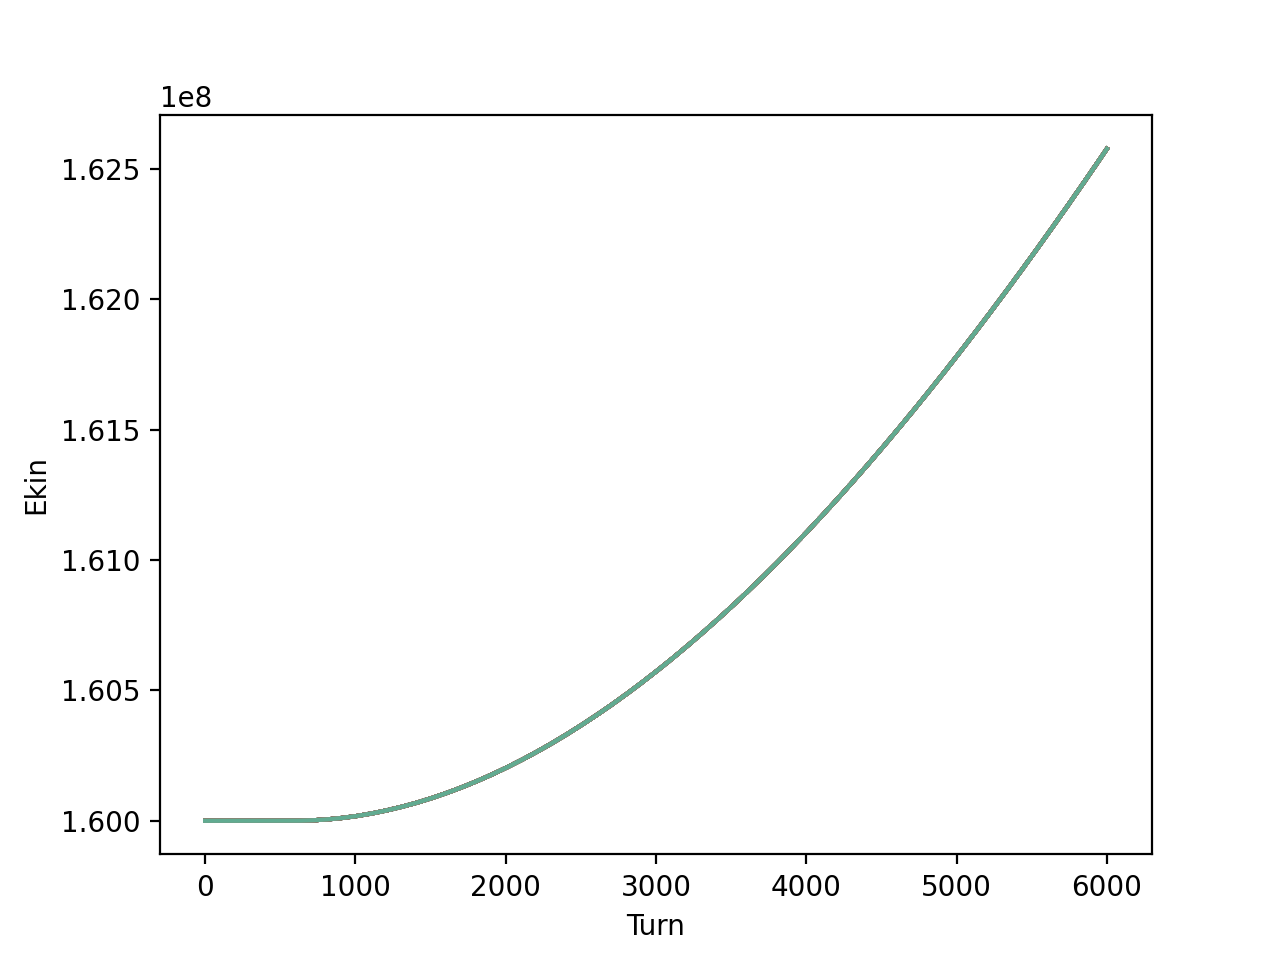

In [22]:
plt.figure(2)
plt.plot(xt.PROTON_MASS_EV * (monitor.gamma0.T - 1), alpha=0.5)
plt.xlabel('Turn')
plt.ylabel('Ekin')
plt.show()

In [23]:
np.mean(monitor.x, axis=1)

array([-0.01898607, -0.01889815, -0.01892499, -0.01902096, -0.01894117,
       -0.01892106, -0.0189592 , -0.01899007, -0.0189173 , -0.01890419,
       -0.01888746, -0.01887618, -0.01887505, -0.0188743 , -0.01887384,
       -0.01887409, -0.01887291, -0.01886602, -0.01885141, -0.01884089,
       -0.01885113, -0.01886427, -0.01886517, -0.01885413, -0.01882254,
       -0.01888982, -0.01891459, -0.01891396, -0.01888284, -0.0188908 ,
       -0.01891008, -0.01889703, -0.01888188, -0.01887735, -0.01887743,
       -0.01887683, -0.01887449, -0.0188724 , -0.01887382, -0.01887263,
       -0.01884522, -0.01885343, -0.01886739, -0.01887533, -0.01877246,
       -0.01886285, -0.01873397, -0.01880227, -0.01887081, -0.0187824 ])

<IPython.core.display.Javascript object>


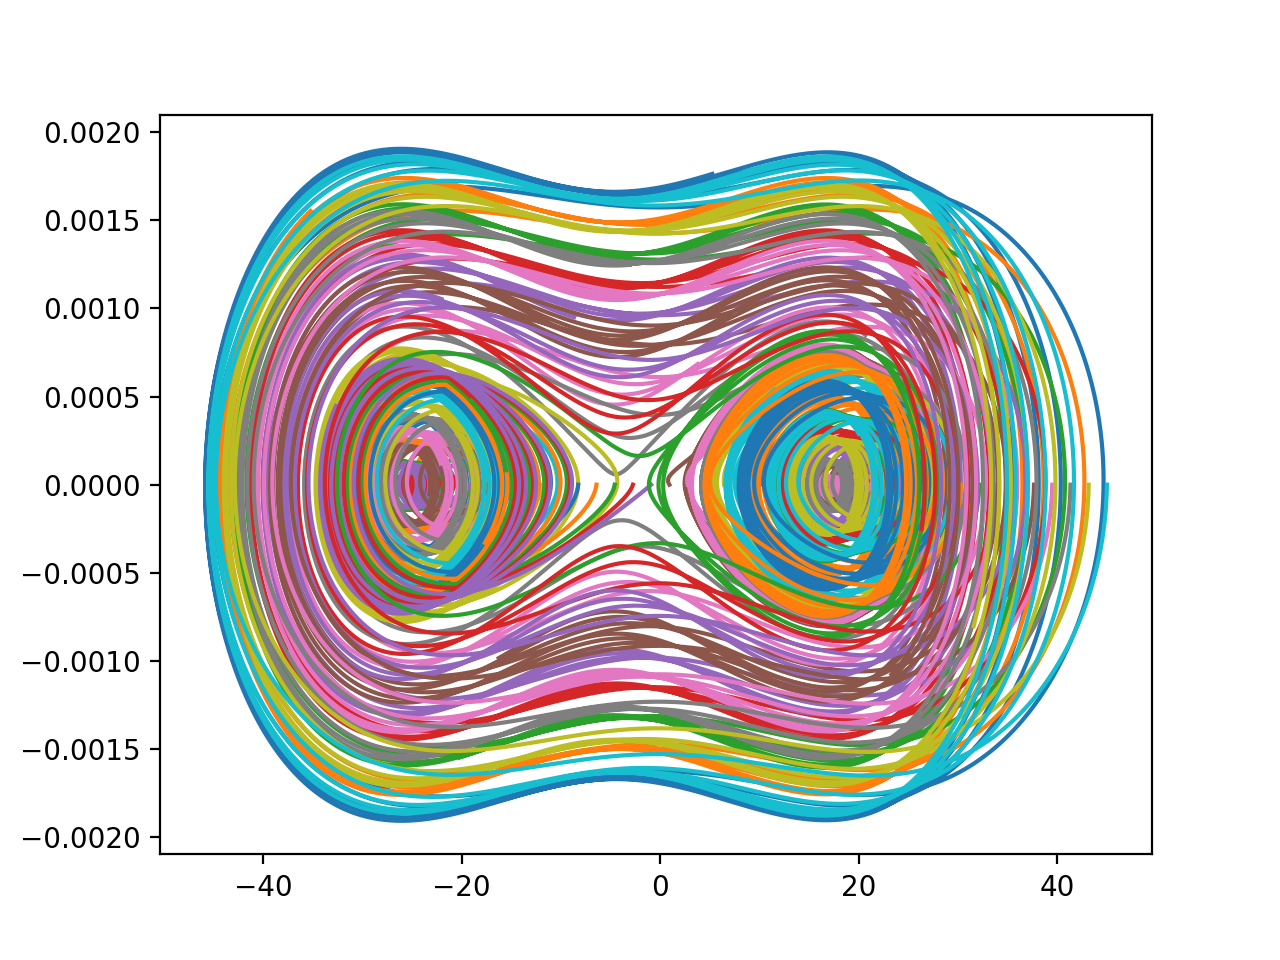

In [24]:
plt.figure(100)
plt.plot(monitor.zeta.T, monitor.delta.T)

In [25]:
line.enable_time_dependent_vars = False

In [ ]:
tw = line.twiss(method='6d')

-------